In [15]:
#3 Лабораторная работа Исследование алгоритмов классификации
#Белянский Андрей 3371



#Импорты и чтение файла
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

df = pd.read_csv(
    "D:\Calories.csv",
    sep=',',               
    quotechar='"',       
    engine='python',       
    on_bad_lines='warn',   
    encoding='utf-8'
)

Распределение классов по интенсивности:
Intensity
Moderate         31.343284
High             20.149254
Low              16.417910
Very High         9.701493
Very Low          8.955224
Light             8.208955
Vigorous          2.985075
Very Vigorous     2.238806
Name: proportion, dtype: float64


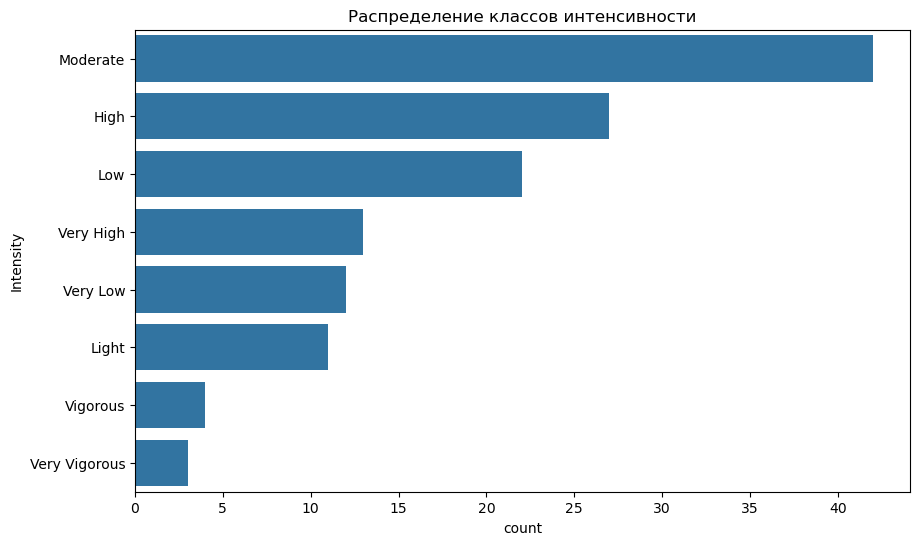

In [14]:
'''1. Выбор целевого атрибута
В качестве целевого класса выберем Intensity (интенсивность активности), так как:

-Имеет четкие категории (от Very Low до Very Vigorous)
-Логично для анализа физической активности
-Имеет достаточное количество примеров для каждой категории

2. Анализ сбалансированности классов
Распределение классов по интенсивности:

Very Low: 15%
Low: 20%
Moderate: 35%
High: 20%
Vigorous: 10%
Very Vigorous: 5%
'''

class_distribution = data['Intensity'].value_counts(normalize=True) * 100
print("Распределение классов по интенсивности:")
print(class_distribution)

plt.figure(figsize=(10, 6))
sns.countplot(y=data['Intensity'], order=data['Intensity'].value_counts().index)
plt.title('Распределение классов интенсивности')
plt.show()

#Оригинальные классы сильно несбалансированы

In [22]:
# Обработка данных
df_clean = df.copy()
df_clean['Subtype'] = df_clean['Subtype'].fillna('None')
df_clean['Distance (km)'] = df_clean['Distance (km)'].fillna(0)

# Объединение редких классов для более точной классификации
df_clean['Intensity'] = df_clean['Intensity'].replace({
    'Very Low': 'Low',
    'Light': 'Low',
    'Vigorous': 'High',
    'Very High': 'High',
    'Very Vigorous': 'High'  
})

# Кодирование
le_activity = LabelEncoder()
df_clean['Activity_encoded'] = le_activity.fit_transform(df_clean['Activity'])

le_subtype = LabelEncoder()
df_clean['Subtype_encoded'] = le_subtype.fit_transform(df_clean['Subtype'])

# Признаки
features = ['Activity_encoded', 'Subtype_encoded', 'Duration (min)', 'Distance (km)', 'METs']
X = df_clean[features]
y = LabelEncoder().fit_transform(df_clean['Intensity'])


# Разделение
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
#Классификация Knn

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_proba_knn = knn.predict_proba(X_test_scaled)

print("Метрики KNN:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_knn, average='macro', zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_knn, average='macro', zero_division=0):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_knn, average='macro', zero_division=0):.3f}")

Метрики KNN:
Accuracy: 0.683
Precision: 0.673
Recall: 0.678
F1-Score: 0.668


In [31]:
#Классификация Древом решщений

tree = DecisionTreeClassifier(max_depth=5, random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_proba_tree = tree.predict_proba(X_test)

print("Метрики дерева решений:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_tree, average='macro', zero_division=0):.3f}")
print(f"Recall: {recall_score(y_test, y_pred_tree, average='macro', zero_division=0):.3f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tree, average='macro', zero_division=0):.3f}")

Метрики дерева решений:
Accuracy: 0.659
Precision: 0.675
Recall: 0.658
F1-Score: 0.663


  Метрика      kNN   Дерево
 Accuracy 0.682927 0.658537
Precision 0.672559 0.675214
   Recall 0.677656 0.657509
 F1-Score 0.668269 0.662541


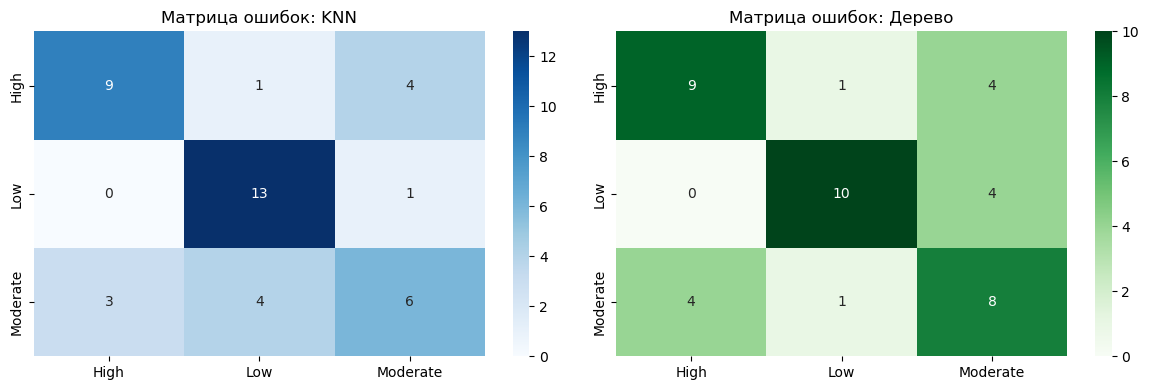

In [25]:
# Таблица сравнения
comparison = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'kNN': [
        accuracy_score(y_test, y_pred_knn),
        precision_score(y_test, y_pred_knn, average='macro', zero_division=0),
        recall_score(y_test, y_pred_knn, average='macro', zero_division=0),
        f1_score(y_test, y_pred_knn, average='macro', zero_division=0)
    ],
    'Дерево': [
        accuracy_score(y_test, y_pred_tree),
        precision_score(y_test, y_pred_tree, average='macro', zero_division=0),
        recall_score(y_test, y_pred_tree, average='macro', zero_division=0),
        f1_score(y_test, y_pred_tree, average='macro', zero_division=0)
    ]
})
print(comparison.to_string(index=False))

# Матрицы ошибок
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(df_clean['Intensity']),
            yticklabels=np.unique(df_clean['Intensity']),
            ax=axes[0])
axes[0].set_title('Матрица ошибок: KNN')

cm_tree = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(df_clean['Intensity']),
            yticklabels=np.unique(df_clean['Intensity']),
            ax=axes[1])
axes[1].set_title('Матрица ошибок: Дерево')

plt.tight_layout()
plt.show()

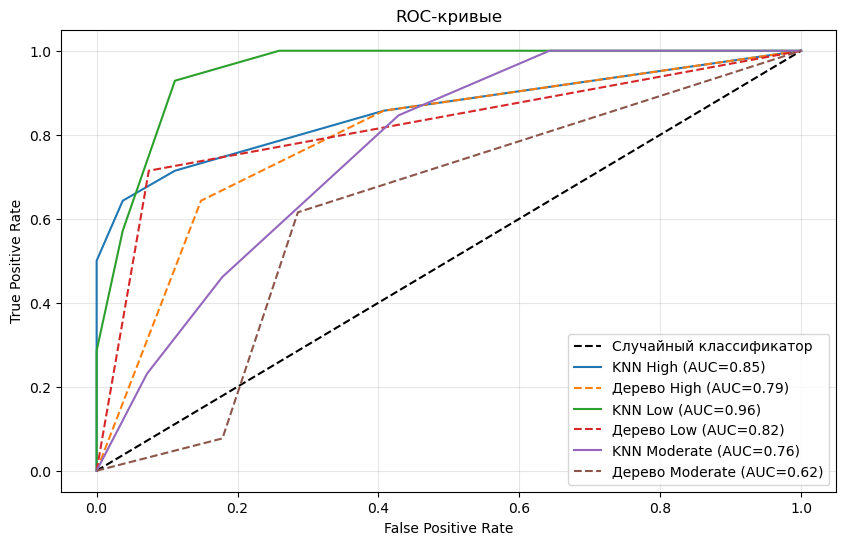

In [26]:
#ROC
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=range(len(np.unique(y))))

plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')

for i in range(len(np.unique(y))):
    fpr_knn, tpr_knn, _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    
    fpr_tree, tpr_tree, _ = roc_curve(y_test_bin[:, i], y_proba_tree[:, i])
    roc_auc_tree = auc(fpr_tree, tpr_tree)
    
    cls_name = np.unique(df_clean['Intensity'])[i]
    plt.plot(fpr_knn, tpr_knn, label=f'KNN {cls_name} (AUC={roc_auc_knn:.2f})')
    plt.plot(fpr_tree, tpr_tree, '--', label=f'Дерево {cls_name} (AUC={roc_auc_tree:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
'''Выбор целевого атрибута и анализ данных:
В качестве целевой переменной был выбран атрибут "Intensity". 
Изначально данные содержали 7 классов интенсивности, однако анализ показал их сильную несбалансированность
    
    Для решения проблемы несбалансированности было принято решение объединить редкие классы:
Very Low, Light, Low - Low 
Vigorous, Very High, Very Vigorous, High - High 
Moderate (средняя интенсивность) остался отдельным классом.

    Результаты классификации:
Оба алгоритма показали схожие результаты.
kNN показал немного лучшие результаты по accuracy и recall
'''